In [70]:
# data manipulation
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import datetime
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# LRFM Analysis
## Store Bike

**Penjelasan kolom**:

1. transaction_id: ID unik untuk setiap transaksi.

2. product_id: ID unik untuk setiap produk yang dibeli.

3. customer_id: ID unik untuk setiap pelanggan yang melakukan transaksi. 

4. transaction_date: Tanggal terjadinya transaksi.

5. online_order: Menunjukkan apakah transaksi dilakukan secara online (TRUE) atau offline (FALSE).


6. order_status: Status pesanan (misalnya, "Approved").

7. brand: Merek produk (misalnya, "Solex", "Trek Bicycles").

8. product_line: Jenis produk (misalnya, "Standard").

9. product_class: Kelas produk (misalnya, "medium").

10. product_size: Ukuran produk (misalnya, "medium", "large").

11. list_price: Harga daftar produk.

12. standard_cost: Biaya standar produk.

13. product_first_sold_date: Tanggal pertama produk dijual. 

# Proses Menarik Data

In [71]:
#proses load data
df_raw= pd.read_csv("store_bike.csv",parse_dates=['transaction_date'])
df_raw.head(5)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,$53.62,41245.0
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,$388.92,41701.0
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,$248.82,36361.0
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,$381.10,36145.0
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,$709.48,42226.0


# Proses Pembersihan Data
Proses ini bertujuan untuk membersihkan data-data yang diperlukan untuk pembuatan analisa LRFM

In [72]:
# Mengecek tipe data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  object        
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  object        
 12  product_first_sold_date  19803 n

In [73]:
#melihat nilai yang tidak terisi
df_raw.isna().sum()

transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64

In [74]:
df_raw.duplicated().sum()

0

In [75]:
df_raw["standard_cost"] = df_raw["standard_cost"].replace('[\$,]', '', regex=True).astype(float)

# Proses Mempersiapkan Data

In [76]:
#Membuang order status yang bernilai cancelled.
#Didasari karena jika order status cancel, maka pembelian tidak terjadi
df_clean=df_raw[df_raw["order_status"]!='Cancelled']

In [77]:
# Mempersiapkan tentang tanggal analisa
analysis_date = df_clean['transaction_date'].max() + datetime.timedelta(1)
analysis_date

Timestamp('2017-12-31 00:00:00')

In [78]:
#Proses pengumpulan data yang dirasa penting untuk dijadikan LRFM
df_lrfm = df_clean.copy()
columns_to_drop = ["online_order","order_status","brand","product_line","product_size","standard_cost", "product_first_sold_date"]
df_lrfm = df_lrfm.drop(columns=columns_to_drop)
df_lrfm

,transaction_id,product_id,customer_id,transaction_date,product_class,list_price
0,1,2,2950,2017-02-25,medium,71.49
1,2,3,3120,2017-05-21,medium,2091.47
2,3,37,402,2017-10-16,low,1793.43
3,4,88,3135,2017-08-31,medium,1198.46
4,5,78,787,2017-10-01,medium,1765.30
...,...,...,...,...,...,...
19995,19996,51,1018,2017-06-24,high,2005.66
19996,19997,41,127,2017-11-09,medium,416.98
19997,19998,87,2284,2017-04-14,medium,1636.90
19998,19999,6,2764,2017-07-03,high,227.88


# Proses LRFM pada data

## Mencari Nilai Length dan Recency
1. `length` adalah berapa lama customer sudah ada pada perusahaan. Dengan kata lain, `length` akan mencari kapan pertama kali customer berinteraksi dengan perusahan. Cara mencarinya adalah `analysis_date` dikurangi dengan pertama kali customer melakukan transaksi (minimum `transaction_date`)

2. `recency` adalah kapan terakkhir kali customer berinteraksi dengan perusahaan.`recency` akan menghasilkan tanggal terakhir customer melakukan transaksi. Maka, cara mencari nilai ini adalah `analysis_date` dikurangi dengan terakhir kali customer melakukan transaksi (maksimum `transaction_date`)

In [79]:
# Mencari nilai length dan recency
df_length_recency = df_lrfm.groupby('customer_id').agg(
    length=("transaction_date", lambda x: (analysis_date - x.min()).days),
    recency=("transaction_date", lambda x: (analysis_date - x.max()).days)
)

df_length_recency

,length,recency
customer_id,,
1,360,8
2,241,129
3,311,103
4,272,196
5,303,17
...,...,...
3497,121,53
3498,331,128
3499,353,52


## Mencari Nilai Frequency
`frequency` adalah nilai seberapa sering customer berinteraksi dengan perusahaan. Hal ini dapat dilihat dari seberapa banyak `transaction_id` yang muncul per customer.

In [80]:
df_frequency = df_lrfm.groupby('customer_id').agg(
    frequency=('transaction_id', lambda x: x.nunique())
)

df_frequency

,frequency
customer_id,
1,11
2,3
3,8
4,2
5,6
...,...
3497,3
3498,6
3499,7


## Mencari Nilai Monetary
`monetary` adalah seberapa besar pengeluaran yang dilakukan oleh customer terhadap perusahaan. Hal ini bisa dilihat dari total `list_price` dari tiap transaksi per customer sehingga mendapatkan total pengeluaran dari masing-masing customer.

In [81]:
df_monetary = df_lrfm.groupby('customer_id').agg(
    monetary=('list_price', 'sum')
)
df_monetary

,monetary
customer_id,
1,9084.45
2,4149.07
3,9888.23
4,1047.72
5,5903.20
...,...
3497,3744.07
3498,5177.06
3499,7673.48


Setelah mendapatkan nilai-nili dari length, recency, frequency, dan monetary, selanjutnya semua digabungkan dalam satu data frame yang baru untuk melihat data secara keseluruhan

## Proses Penggabungan Data LRFM

In [82]:
df_customer = df_lrfm.groupby("customer_id").agg(
    length=("transaction_date", lambda x: (analysis_date - x.min()).days),
    recency=("transaction_date", lambda x: (analysis_date - x.max()).days),
    frequency=('transaction_id', lambda x: x.nunique()),
    monetary=('list_price', 'sum')
)
df_customer

,length,recency,frequency,monetary
customer_id,,,,
1,360,8,11,9084.45
2,241,129,3,4149.07
3,311,103,8,9888.23
4,272,196,2,1047.72
5,303,17,6,5903.20
...,...,...,...,...
3497,121,53,3,3744.07
3498,331,128,6,5177.06
3499,353,52,7,7673.48


# Pemberian Skor dan Kategorisasi dari data LRFM

## Pemberian Skor Terhadap Data LRFM
Pemberian skor ini bertujuan untuk menjadi dasar penilaian untuk masing-masing customer supaya nantinya bisa dikategorisasikan berdasarkan perilaku customer tersebut terhadap perusahaan.

Penentuan skor ini menggunakan pendekatan statistika dari masing-masing kolomnya. Pendekatan statistika yang dimaksud adalah menggunakan pengelompokan quantil dari tiap-tiap kolom untuk menentukan penilaian.

In [83]:
# Mencari nilai quantil untuk tiap-tiap kolom
print("length", df_customer["length"].quantile([0, 0.25, 0.5, 0.75, 1]))
print("recency", df_customer["recency"].quantile([0, 0.25, 0.5, 0.75, 1]))
print("frequency",df_customer["frequency"].quantile([0, 0.25, 0.5, 0.75, 1]))
print("monetary", df_customer["monetary"].quantile([0, 0.25, 0.5, 0.75, 1]))

length 0.00      8.0
0.25    275.0
0.50    321.0
0.75    346.0
1.00    364.0
Name: length, dtype: float64
recency 0.00      1.0
0.25     18.0
0.50     45.0
0.75     87.0
1.00    354.0
Name: recency, dtype: float64
frequency 0.00     1.0
0.25     4.0
0.50     6.0
0.75     7.0
1.00    14.0
Name: frequency, dtype: float64
monetary 0.00       60.34
0.25     4162.96
0.50     5974.77
0.75     8157.72
1.00    19071.32
Name: monetary, dtype: float64


Pembagian nilai-nilai quantil di atas akan menjadi acuan untuk setiap penilaian kolomnya.

Kolom `length` akan dikelompokan ke 4 penilaian dengan menganggap semakin **besar** angka `length` maka, semakin baik juga nilainya (Nilai akan besar). Pembagiannya yaitu:
- Nilai 4 (Sangat Lama): nilainya di atas 346
- Nilai 3 (Lama): nilainya di antara 346 dan 321
- Nilai 2 (Normal): nilainya di antara 321 dan 275
- Nilai 1 (Baru): nilainya di bawah 275

Kolom `recency` akan dikelompokan ke 4 penilaian dengan menganggap semakin **kecil** angka `recency` maka, semakin baik juga nilainya (Nilai akan besar). Pembagiannya yaitu:
- Nilai 4 (Baru): nilainya di bawah 18
- Nilai 3 (Normal): nilainya di antara 18 dan 45
- Nilai 2 (Lama): nilainya di antara 45 dan 87
- Nilai 1 (Sangat Lama): nilainya di atas 87

Kolom `frequency` akan dikelompokan ke 4 penilaian dengan menganggap semakin **besar** angka `frequency` maka, semakin baik juga nilainya (Nilai akan besar). Pembagiannya yaitu:
- Nilai 4 (Sangat Sering): nilainya di atas 7
- Nilai 3 (Sering): nilainya di antara 7 dan 6
- Nilai 2 (Normal): nilainya di antara 6 dan 4
- Nilai 1 (Jarang): nilainya di bawah 4

Kolom `monetary` akan dikelompokan ke 4 penilaian dengan menganggap semakin **besar** angka `monetary` maka, semakin baik juga nilainya (Nilai akan besar). Pembagiannya yaitu:
- Nilai 4 (Sangat besar): nilainya di atas 8157.72
- Nilai 3 (Cukup besar): nilainya di antara 8157.72 dan 5974.77
- Nilai 2 (Normal): nilainya di antara 5974.77 dan 4162.96
- Nilai 1 (Sedikit): nilainya di bawah 4162.96

Setelah mengetahui acuan penilaiannya dengan menggunakan quantil dari masing-masing kolom, bisa dilakukan pemberian skor menggunakan `pd.cut` untuk mengelompokkannya ke dalam rentang quantil masing-masing

In [84]:
df_customer['l_score'] = pd.qcut(
    df_customer['length'],        
    q=4,                                
    labels=[1, 2, 3, 4]
).astype(int)

df_customer['r_score'] = pd.qcut(
    df_customer['recency'],       
    q=4,        
    labels=[4, 3, 2, 1]
).astype(int)

df_customer['f_score'] = pd.qcut(
    df_customer['frequency'],        
    q=4,                                
    labels=[1, 2, 3, 4]
).astype(int)

df_customer['m_score'] = pd.qcut(
    df_customer['monetary'],        
    q=4,                                
    labels=[1, 2, 3, 4]
).astype(int)

df_customer

,length,recency,frequency,monetary,l_score,r_score,f_score,m_score
customer_id,,,,,,,,
1,360,8,11,9084.45,4,4,4,4
2,241,129,3,4149.07,1,1,1,1
3,311,103,8,9888.23,2,1,4,4
4,272,196,2,1047.72,1,1,1,1
5,303,17,6,5903.20,2,4,2,2
...,...,...,...,...,...,...,...,...
3497,121,53,3,3744.07,1,2,1,1
3498,331,128,6,5177.06,3,1,2,2
3499,353,52,7,7673.48,4,2,3,3


## Pemberian Kategorisasi Perilaku Customer

Berdasarkan hasil skor yang sudah dicari pada proses sebelumnya, kategorisasi bisa dilakukan untuk mengelompokan perilaku customer terhadap perusahaan. Hal ini bisa dilakukan dengan menganalisa skor dari masing-masing LRFM.

### Kategorisasi berdasarkan Total Skor

In [85]:
df_customer['lrfm_score_total'] = df_customer['l_score'] + df_customer['r_score'] + df_customer['f_score'] + df_customer['m_score']
df_customer

,length,recency,frequency,monetary,l_score,r_score,f_score,m_score,lrfm_score_total
customer_id,,,,,,,,,
1,360,8,11,9084.45,4,4,4,4,16
2,241,129,3,4149.07,1,1,1,1,4
3,311,103,8,9888.23,2,1,4,4,11
4,272,196,2,1047.72,1,1,1,1,4
5,303,17,6,5903.20,2,4,2,2,10
...,...,...,...,...,...,...,...,...,...
3497,121,53,3,3744.07,1,2,1,1,5
3498,331,128,6,5177.06,3,1,2,2,8
3499,353,52,7,7673.48,4,2,3,3,12


Selanjutnya, dari `lrfm_score_total` bisa dimasukan lagi ke kategorisasi penilaian untuk dicari segmentasinya berdasarkan hasil tersebut. Akan dibagi ke dalam empat kategori, yaitu:
- Elite Rider = Customer dengan nilai tinggi
- Priority Rider = Customer dengan nilai di atas rata-rata
- Sport Rider =  Customer dengan nilai rata-rata
- Fun Rider = Customer dengan nilai di bawah rata-rata

Penamanaan ini didasari dengan sistem kategorisasi di dunia olahraga bersepeda. Adapun penilaiannya akan mengacu pada uji statistika dari total skor LRFM dan bisa langsung menggunakan `pd.qcut`.

In [86]:
#Mengkategorisasi berdasarkan skor LRFM
df_customer['Kategori'] = pd.qcut(
    df_customer['lrfm_score_total'],        
    q=4,                                
    labels=["Fun Rider", "Sport Rider", "Priority Rider", "Elite Rider"]
)

df_customer

,length,recency,frequency,monetary,l_score,r_score,f_score,m_score,lrfm_score_total,Kategori
customer_id,,,,,,,,,,
1,360,8,11,9084.45,4,4,4,4,16,Elite Rider
2,241,129,3,4149.07,1,1,1,1,4,Fun Rider
3,311,103,8,9888.23,2,1,4,4,11,Priority Rider
4,272,196,2,1047.72,1,1,1,1,4,Fun Rider
5,303,17,6,5903.20,2,4,2,2,10,Sport Rider
...,...,...,...,...,...,...,...,...,...,...
3497,121,53,3,3744.07,1,2,1,1,5,Fun Rider
3498,331,128,6,5177.06,3,1,2,2,8,Sport Rider
3499,353,52,7,7673.48,4,2,3,3,12,Priority Rider


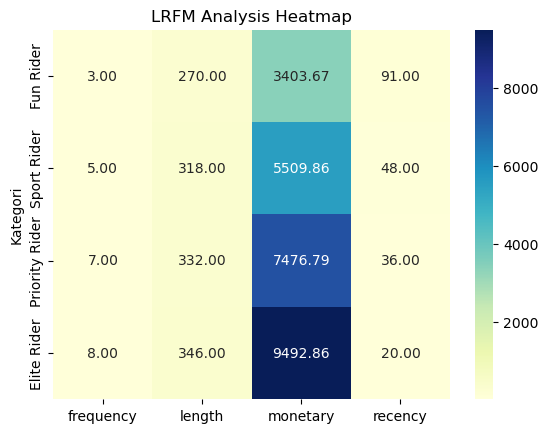

In [87]:
lrfm_heatmap = df_customer.pivot_table(index='Kategori', values=['length', 'recency', 'frequency', 'monetary'], aggfunc='median')

# Create the heatmap
sns.heatmap(lrfm_heatmap, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('LRFM Analysis Heatmap')
plt.show()

In [88]:
import plotly.express as px

color_map = {'Fun Rider' : 'brown', 'Sport Rider' : 'gray', 'Priority Rider' : 'orange', 'Elite Rider' : 'red'}

fig = px.scatter_3d(
    df_customer, 
    x='recency', 
    y='frequency', 
    z='monetary',
    color='Kategori', 
    color_discrete_map=color_map, 
)
                          
fig.update_traces(marker_size = 3)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  title={
                    'text': "RFM segmentation",
                    'y':0.97,
                    'x':0.45,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                    legend=dict(
                      yanchor="top",
                      y=0.97,
                      xanchor="left",
                      x=0.70,
                      itemsizing='constant',
                      itemwidth = 30))

fig.update_xaxes(tickformat=".0f")

### Kategorisasi Detail LRFM
Kategorisasi detail ini ditujukan untuk menjadi laporan bagi perusahaan berdasarkan detail perilaku dari customer. Perilaku ini berdasar pada nilai length, recency, frequency dan monetary (bukan total nilainya). Hal ini berguna untuk menentukan langkah-langkah perusahaan untuk tiap-tiap customernya

In [89]:
#Menggabungkan tiap-tiap nilai pada satu kolom baru
df_customer['lrfm_score_gabungan'] = df_customer['l_score'].astype(str) + df_customer['r_score'].astype(str) + df_customer['f_score'].astype(str) + df_customer['m_score'].astype(str)
df_customer

,length,recency,frequency,monetary,l_score,r_score,f_score,m_score,lrfm_score_total,Kategori,lrfm_score_gabungan
customer_id,,,,,,,,,,,
1,360,8,11,9084.45,4,4,4,4,16,Elite Rider,4444
2,241,129,3,4149.07,1,1,1,1,4,Fun Rider,1111
3,311,103,8,9888.23,2,1,4,4,11,Priority Rider,2144
4,272,196,2,1047.72,1,1,1,1,4,Fun Rider,1111
5,303,17,6,5903.20,2,4,2,2,10,Sport Rider,2422
...,...,...,...,...,...,...,...,...,...,...,...
3497,121,53,3,3744.07,1,2,1,1,5,Fun Rider,1211
3498,331,128,6,5177.06,3,1,2,2,8,Sport Rider,3122
3499,353,52,7,7673.48,4,2,3,3,12,Priority Rider,4233


Dikelompokan menjadi 6 segmmen untuk mengetahui perilaku customer

In [90]:
segmentasi = {
    # L-R-F-M
    r'[1-2][1-4][1-4][1-2]': 'Pelanggan Baru - Potensi Rendah', #Length baru, monetary sedikit
    r'[1-2][1-4][1-4][3-4]': 'Pelanggan Baru - Potensi Tinggi', #Length baru, monetary besar
    r'[3-4][1-2][1-2][1-4]': 'Pelanggan Tidak Aktif', #length lama, recency lama tidak aktif, freq rendah
    r'[3-4][1-2][3-4][3-4]': 'Pelanggan Berisiko', #length lama, recency lama tidak aktif, freq (dulunya) sering, monetary tinggi
    r'[3-4][3-4][3-4][1-2]': 'Pelanggan Potensial Berkembang', #length lama, recency baru, freq sering beli, monetary masih kecil
    r'[3-4][3-4][3-4][3-4]': 'Pelanggan Loyal Strategis', #semua nilainya tinggi
    r'[1-4][1-4][1-4][1-4]': 'Pelanggan Umum', #mengkategorikan yang tidak masuk dikategori lain
}

df_customer['lrfm_score_gabungan'] = df_customer['lrfm_score_gabungan'].replace(segmentasi, regex=True)
df_customer

,length,recency,frequency,monetary,l_score,r_score,f_score,m_score,lrfm_score_total,Kategori,lrfm_score_gabungan
customer_id,,,,,,,,,,,
1,360,8,11,9084.45,4,4,4,4,16,Elite Rider,Pelanggan Loyal Strategis
2,241,129,3,4149.07,1,1,1,1,4,Fun Rider,Pelanggan Baru - Potensi Rendah
3,311,103,8,9888.23,2,1,4,4,11,Priority Rider,Pelanggan Baru - Potensi Tinggi
4,272,196,2,1047.72,1,1,1,1,4,Fun Rider,Pelanggan Baru - Potensi Rendah
5,303,17,6,5903.20,2,4,2,2,10,Sport Rider,Pelanggan Baru - Potensi Rendah
...,...,...,...,...,...,...,...,...,...,...,...
3497,121,53,3,3744.07,1,2,1,1,5,Fun Rider,Pelanggan Baru - Potensi Rendah
3498,331,128,6,5177.06,3,1,2,2,8,Sport Rider,Pelanggan Tidak Aktif
3499,353,52,7,7673.48,4,2,3,3,12,Priority Rider,Pelanggan Berisiko


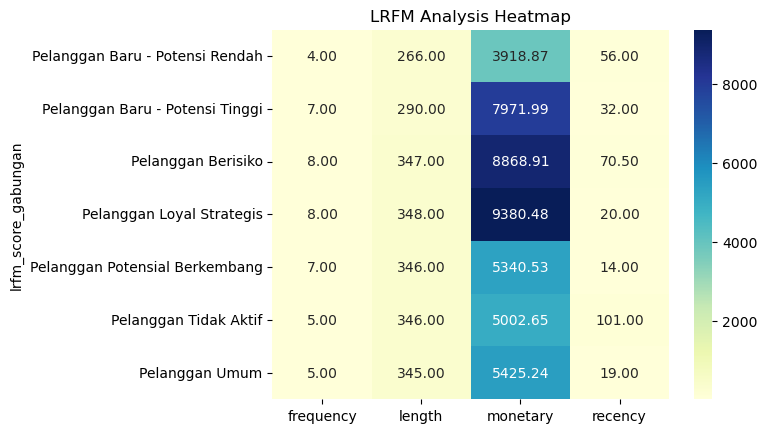

In [91]:
lrfm_heatmap = df_customer.pivot_table(index='lrfm_score_gabungan', values=['length', 'recency', 'frequency', 'monetary'], aggfunc='median')

# Create the heatmap
sns.heatmap(lrfm_heatmap, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('LRFM Analysis Heatmap')
plt.show()

In [92]:
import plotly.express as px

color_map = {
    'Pelanggan Baru - Potensi Rendah' : 'gray',
    'Pelanggan Baru - Potensi Tinggi' : 'purple',
    'Pelanggan Tidak Aktif' : 'pink',
    'Pelanggan Berisiko' : 'blue',
    'Pelanggan Potensial Berkembang' : 'green',
    'Pelanggan Loyal Strategis' : 'yellow', 
    'Pelanggan Umum' : 'orange', 
}

fig = px.scatter_3d(
    df_customer, 
    x='recency', 
    y='frequency', 
    z='monetary',
    color='lrfm_score_gabungan', 
    color_discrete_map=color_map, 
)
                          
fig.update_traces(marker_size = 3)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  title={
                    'text': "RFM segmentation",
                    'y':0.97,
                    'x':0.45,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                    legend=dict(
                      yanchor="top",
                      y=0.97,
                      xanchor="left",
                      x=0.70,
                      itemsizing='constant',
                      itemwidth = 30))

fig.update_xaxes(tickformat=".0f")

# Kesimpulan dan Rekomendasi

Kesimpulan:
1. Customer berdasarkan kategori perilakunya:
- Terdapat 754 customer yang masuk kategori Elite Rider
- Terdapat 697 customer yang masuk kategori Priority Rider
- Terdapat 1077 customer yang masuk kategori Sport Rider
- Terdapat 965 customer yang masuk kategori Fun Rider

2. Customer berdasarkan pemahaman untuk kebutuhan perusahaan:
-  Terdapat 719 customer sebagai Pelanggan baru - potensi tinggi (Maintain performance)
- Terdapat 432 customer sebagai Pelanggan loyal strategis  (Maintain performance)
- Terdapat 36 customer sebagai potensial berkembang (Maintain performance)
- Terdapat 1055 customer sebagai Pelanggan baru - potensi rendah (Need improvement)
- Terdapat 415 customer sebagai Pelanggan Umum (Need improvement)
- Terdapat 590 customer sebagai Pelanggan tidak aktif (Need attention)
- Terdapat 246 customer sebagai Pelanggan beresiko tinggi (Need attention)

rekomendasi:
1. Rekomendasi: Pelanggan Baru Potensi Tinggi 
    - Edukasi 
    - Retargeting produk premium
2. Rekomendasi: Pelanggan Loyal Strategis
    - Program loyalitas
    - VIP
    - Ajukan ke brand untuk menjadi ambassador
    - Tawarkan Pre-order
3. Rekomendasi: Pelanggan Potensial Berkembang
    - Kirim rekomendasi produk berbasis histori pembelian
4. Rekomendasi: Pelanggan Baru Potensi Rendah
    - Berikan diskon untuk pembelian kedua
    - Edukasi produk melalui email atau sosial media
    - minta ulasan atau feedback
5. Rekomendasi: Pelanggan Umum
    - Dorong pembelian lebih besar lewat bundling produk
    - Tawarkan untuk ikut challenge atau campaign berhadiah
6. Rekomendasi: Pelanggan Tidak Aktif
    - Kirim kampanye reaktivasi dengan tawaran diskon
    - Email “what’s new” dengan produk baru atau tren terkini
    - Ajak nostalgia dengan produk yang pernah dibeli
    - Minta ulasan atau feedback
7. Rekomendasi: Pelanggan Berisiko
    - Kirim kampanye reaktivasi dengan tawaran diskon
    - Berikan promo “barang trend” yang tersedia
    - Minta ulasan atau feedback

Rekomendasi umum untuk tiap tier:
1. Elite Rider → Pertahankan, beri reward
2. Priority → Dorong upgrade
3. Sport → Dorong loyalitas
4. Fun → Campaign awareness / edukasi ulang


        